# Week 11 - Variational inference - Automatic Relevance Determination (ARD)

Welcome to week 11! In this part, you will learn about Automatic Relevance Determination (ARD).

The usual imports...

In [1]:
import numpy as np
import scipy.special
from matplotlib import pyplot as plt

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# matplotlib options (for some reason, in many computers, needs to be run twice to take effect...)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

## Generate artificial data

We begin by generating artificial data. This follows more or less the generative process of a Bayesian linear regression model. However, it has one important caveat: the weights are only non-zero for a small subset of the input dimensions of size D_eff. This means that **only D_eff input features will be relevant for determining the outputs y. The remaining D-D_eff input features will be just noise**.

In [3]:
N = 100
D = 100 
D_eff = 10 # subset of relevant features/input dimensions
N_test = 100

# X's are fixed (always given); we sample these point uniformly in the range [-0.5, 0.5]
X = np.random.rand(N,D) - 0.5
X_test = np.random.rand(N_test,D) - 0.5

# sample weights w
w = np.concatenate([100.0*np.random.normal(size=D_eff), np.zeros(D - D_eff)])
print(w)

# sample observations y (for train and test inputs)
noise = 0.1
y = np.dot(X, w) + noise*np.random.normal(size=N) 
y_test = np.dot(X_test, w) + noise*np.random.normal(size=N_test) 

[ -80.38031801   58.5991769   130.62804757 -122.69156763  171.23077284
  -12.85510344  -97.50213849   75.77547802  -44.64544783   -8.1736676
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.      

## Bayesian linear regression (exact inference)

We will now try to fit a standard Bayesian linear regression model to this artificial data.

Generative process:

1. Draw weights $\textbf{w} \sim \mathcal{N}(\textbf{w} | \textbf{0}, \alpha^{-1} \textbf{I})$
2. For each $n \in \{1,\dots,N\}$:
    3. Draw target $y_n \sim \mathcal{N}(y_n|\textbf{w}^T \textbf{x}_n, \sigma^2)$

As we saw in the previous lectures, since both our prior $p(\textbf{w}|\alpha)$ and likelihood $p(y_n|\textbf{x}_n,\textbf{w},\sigma)$ are both Gaussian, and the Gaussian is the conjugate prior for mean of a Gaussian (with fixed variance), we directly apply Bayes' theorem to compute the posterior distribution over $\textbf{w}$:

\begin{align}
\underbrace{p(\textbf{w}|\textbf{y},\textbf{X})}_{\text{posterior}} &\propto \underbrace{p(\textbf{w}|\textbf{0},\alpha^{-1}\textbf{I})}_{\text{prior}} \, \underbrace{\prod_{n=1}^N p(y_n|\textbf{w}^T \textbf{x}_n, \sigma^2)}_{\text{likelihood}} = \mathcal{N}(\textbf{w}|\textbf{0},\alpha^{-1}\textbf{I}) \prod_{n=1}^N \mathcal{N}(y_n|\textbf{w}^T \textbf{x}_n, \sigma^2) = \mathcal{N}(\textbf{m}_N,\textbf{V}_N)
\end{align}

where 

\begin{align}
\textbf{m}_N &= \textbf{V}_N \, (\sigma^{-2} \textbf{X}^T \textbf{y})
\end{align}

\begin{align}
\textbf{V}_N &= (\alpha + \sigma^{-2} \textbf{X}^T \textbf{X})^{-1}
\end{align}

Notation detail: we use the subscript $N$ to denote that the variable corresponds to the posterior distribution after having observed $N$ data points.

Lets implement it to see how it does in our artificial data.

In [4]:
# specify fixed hyper-parameters - Q: how can you tune these?
alpha = 1.0
sigma2 = 1.0

# run exact inference
V_N_exact = np.linalg.inv(alpha + np.dot(X.T, X)/sigma2)
m_N_exact = np.dot(V_N_exact, np.dot(X.T, y)/sigma2)

# make predictions for test data
y_pred = np.dot(m_N_exact, X_test.T)

# compute root mean squared error for the predictions
print("RMSE:", np.sqrt(np.mean((y_test - y_pred)**2)))

RMSE: 11.558741186279683


We can also plot the mean of the posterior distribution of the weights $\textbf{m}_N$ (in absolute value $|\textbf{m}_N|$):

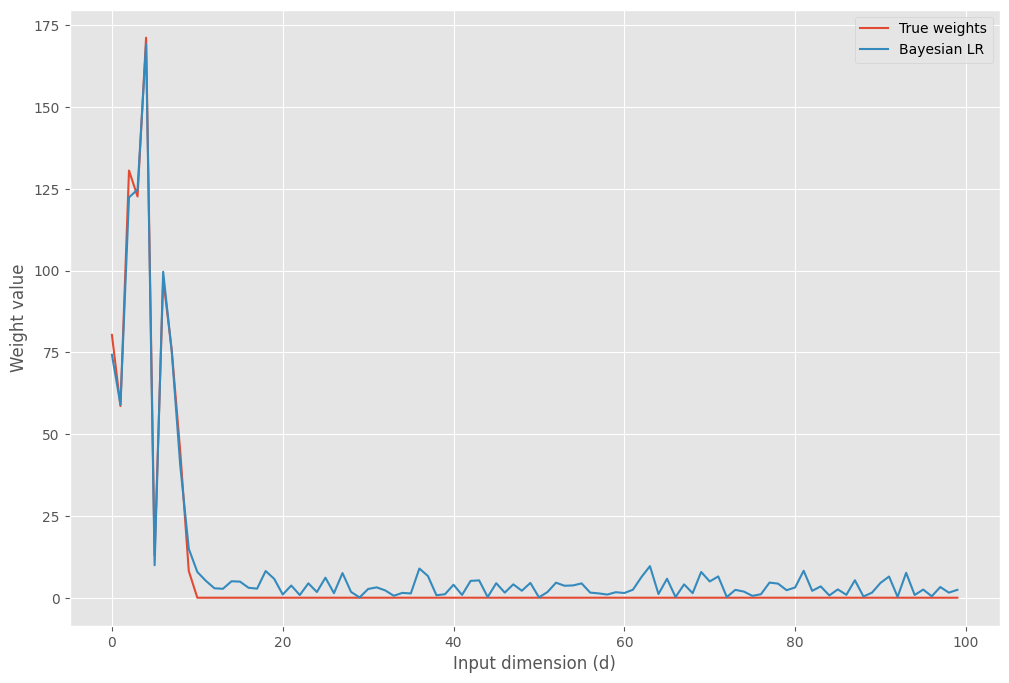

In [5]:
plt.plot(np.abs(w))
plt.plot(np.abs(m_N_exact))
plt.xlabel("Input dimension (d)")
plt.ylabel("Weight value")
plt.legend(["True weights", "Bayesian LR"])
plt.show()

We can observe that the first 10 dimentions of the input data clearly have significantly larger weights, but the remaining input dimensions still have non-neglectible weight values.

## Bayesian linear regression + ARD (variational inference)

1. For each input dimension $j \in \{1,\dots,D\}$:
    2. Draw weight precision $\alpha_j \sim \text{Ga}(\alpha_j | a_0, b_0)$
3. Draw weights $\textbf{w} \sim \mathcal{N}(\textbf{w} | \textbf{0}, \boldsymbol\alpha^{-1} \textbf{I})$
4. For each $n \in \{1,\dots,N\}$:
    5. Draw target $y_n \sim \mathcal{N}(y_n|\textbf{w}^T \textbf{x}_n, \sigma^2)$
    
where $\boldsymbol\alpha = \{\alpha_1, \dots, \alpha_D\}$.

### Step 1: Setup

The joint distribution is given by:

\begin{align}
    p(\textbf{y},\textbf{w},\boldsymbol\alpha | \textbf{X}) &= \mathcal{N}(\textbf{w} | \textbf{0}, \boldsymbol\alpha^{-1}\textbf{I}) \, \Bigg( \prod_{j=1}^D \text{Ga}(\alpha_j | a_0, b_0) \Bigg)  \, \prod_{n=1}^N \mathcal{N}(y_n|\textbf{w}^T \textbf{x}_n, \sigma^2) \nonumber
\end{align}

where $\textbf{y} = \{y_1,\dots,y_K\}$ and $\textbf{X} = \{X_1,\dots,X_N\}$.

Our goal is to compute the posterior over $\textbf{w}$ and $\boldsymbol\alpha$ given the observations $\textbf{y}$:

\begin{align}
    p(\textbf{w}, \boldsymbol\alpha | \textbf{y}, \textbf{X}) = \frac{p(\textbf{y},\textbf{w},\boldsymbol\alpha | \textbf{X})}{\int_{\textbf{w}} \int_{\boldsymbol\alpha} p(\textbf{y},\textbf{w},\boldsymbol\alpha | \textbf{X})} \nonumber
\end{align}

In variational inference, namely in mean-field variational inference, we approximate $p(\textbf{w}, \boldsymbol\alpha | \textbf{y}, \textbf{X})$ with a fully-factorized distribution $q(\textbf{w}, \boldsymbol\alpha)$:

\begin{align}
    q(\textbf{w}, \boldsymbol\alpha) = \mathcal{N}(\textbf{w}|\textbf{m}_N,\textbf{V}_N) \, \prod_{j=1}^D \text{Ga}(\alpha_j|a_{Nj},b_{Nj})\nonumber
\end{align}

Our goal is to find the variational parameters $\textbf{m}_N$, $\textbf{V}_N$, $a_{Nj}$ and $b_{Nj}$ that maximize the ELBO $\mathcal{L}(q)$:

\begin{align}
	\mathcal{L}(q) &= \mathbb{E}_q[ \log p(\textbf{y},\textbf{w},\boldsymbol\alpha | \textbf{X}) ] - \mathbb{E}_q[ \log q(\textbf{w}, \boldsymbol\alpha) ] \nonumber
\end{align}

### Step 2: Computing the ELBO

Because $q$ is fully factorized, the expectations in $\mathcal{L}(q)$ decompose into sums of simpler terms:

\begin{align}
	\mathbb{E}_q[ \log p(\textbf{y},\textbf{w},\boldsymbol\alpha | \textbf{X}) ] = \mathbb{E}_q[\log \mathcal{N}(\textbf{w} | \textbf{0}, \boldsymbol\alpha^{-1}\textbf{I})] + \sum_{j=1}^D \mathbb{E}_q[ \log \text{Ga}(\alpha_j | a_0, b_0)] + \sum_{n=1}^N \mathbb{E}_q[\log \mathcal{N}(y_n|\textbf{w}^T \textbf{x}_n,\sigma^2) ]\nonumber
\end{align}

\begin{align}
	\mathbb{E}_q[ \log q(\textbf{w}, \boldsymbol\alpha) ] &= \mathbb{E}_q[\log \mathcal{N}(\textbf{w}|\textbf{m}_N,\textbf{V}_N)] + \sum_{j=1}^D \mathbb{E}_q[\log \text{Ga}(\alpha_j|a_{Nj},b_{Nj})] \nonumber
\end{align}

Now, we have to compute the required terms (expectations). It is a bit cumbersome, but generally easy... 

### Step 3: Determining the coordinate ascent updates

Once we have the analytical expression for the evidence lower bound (ELBO), $\mathcal{L}(q)$, the next step is to maximize it with respect to the variational parameters $\textbf{m}_N$, $\textbf{V}_N$, $a_{Nj}$ and $b_{Nj}$. For that, we shall use coordinate ascent.

In coordinate ascent, we iteratively optimize each of the variational parameters in $q(\textbf{w}, \boldsymbol\alpha)$ in turn, holding the others fixed, until a convergence criteria is met. 

In order to maximize the ELBO with respect to a variational parameter, we find the terms in the ELBO $\mathcal{L}(q)$ that contain it, then we take derivatives of the ELBO with respect to that parameter and set them to zero. Doing so, yields the following coordinate ascent updates:

\begin{align}
    \textbf{m}_N &= \textbf{V}_N \, (\sigma^{-2} \textbf{X}^T \textbf{y}) \nonumber
\end{align}

\begin{align}
	\textbf{V}_N &= (\mathbb{E}_q [\boldsymbol\alpha] \, \textbf{I} + \sigma^{-2} \textbf{X}^T \textbf{X})^{-1} \nonumber
\end{align}

\begin{align}
	a_{Nj} &= a_0 + \frac{1}{2}\nonumber
\end{align}

\begin{align}
	b_{Nj} &= b_0 + \frac{1}{2} \Big( (m_{Nj})^2 + (\textbf{V}_N)_{jj} \Big)\nonumber
\end{align}

where $\mathbb{E}_q [\alpha_j] = \frac{a_{Nj}}{b_{Nj}}$ (check what the mean of a Gamma distribution is: https://en.wikipedia.org/wiki/Gamma_distribution). 

Compare these updates with the exact solution for standard Bayesian linear regression used above for $\textbf{m}_N$ and $\textbf{V}_N$. Quite similar, right? What is new? 

### Step 4: Implementation

Once we determined closed-form solutions for the coordinate ascent updates (note that this is not always possible!!), we are ready to implement variational inference algorithm.

In [6]:
# specify fixed hyper-parameters - Q: how can you tune these?
a_0 = 10.0
b_0 = 10.0
sigma2 = 1.0

# create data structures for keeping variational parameters
a_N = a_0   # initialize with prior
b_N = b_0 * np.ones(D)   # initialize with prior
m_N = np.zeros((D,))
V_N = np.eye(D)

# run variational inference
for iteration in range(10):
    print("\niteration:", iteration+1)
    
    # TODO: update variational parameters
    raise Exception("TODO")

    # make predictions for test data
    y_pred = np.dot(m_N, X_test.T)

    # compute root mean squared error for the predictions
    print("RMSE:", np.sqrt(np.mean((y_test - y_pred)**2)))



iteration: 1
RMSE: 11.558741186279683

iteration: 2
RMSE: 2.2895479378486576

iteration: 3
RMSE: 1.578048455669834

iteration: 4
RMSE: 1.558199060334948

iteration: 5
RMSE: 1.5586313786666672

iteration: 6
RMSE: 1.5588844424443578

iteration: 7
RMSE: 1.558928843243291

iteration: 8
RMSE: 1.5589352043177012

iteration: 9
RMSE: 1.5589360468151892

iteration: 10
RMSE: 1.5589361542345772


(Again, notice how fast this VI algorithm is compared to running MCMC (e.g. NUTS) or even ADVI in STAN!)

Compare this RMSE with the one from the standard Bayesian linear regression model. Uau! Increadibly better, right? What is happening? How do you explain these results?

Lets look at the mean of the posterior distribution over the weights from this ARD model and compare them with the one from standard Bayesian linear regression and also with the true values used to generate the artificial data:

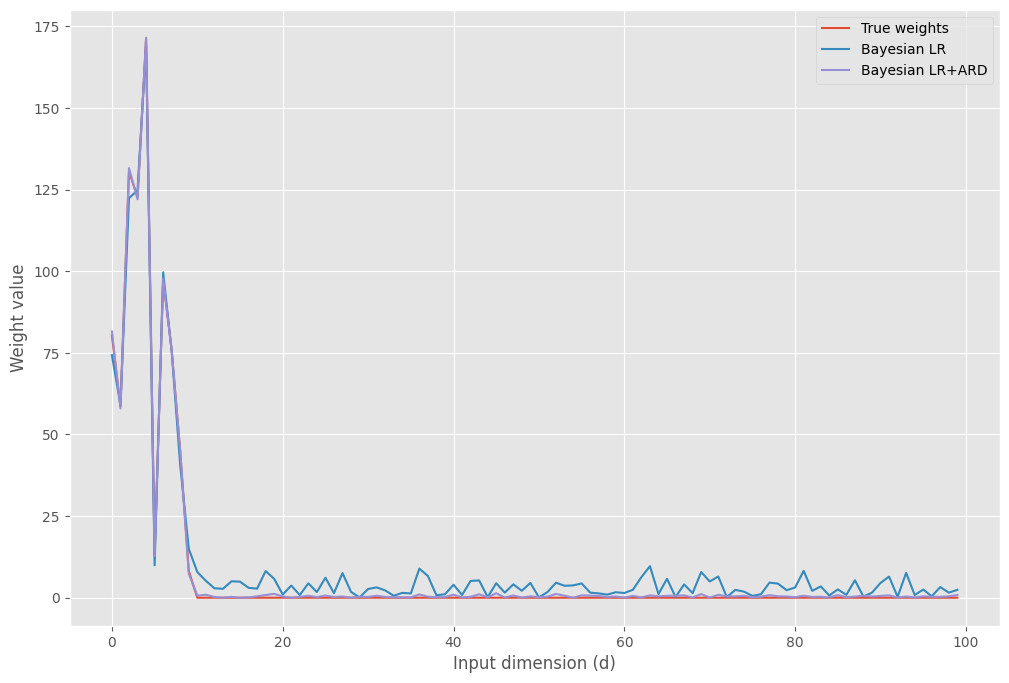

In [7]:
plt.plot(np.abs(w))
plt.plot(np.abs(m_N_exact))
plt.plot(np.abs(m_N))
plt.xlabel("Input dimension (d)")
plt.ylabel("Weight value")
plt.legend(["True weights", "Bayesian LR", "Bayesian LR+ARD"])
plt.show()

We can observe that, while the Bayesian LR model assigned some non-zero value for the irrelevant input dimensions, the ARD model pushes these towards zero.

Let us now plot the values of $b_N$:

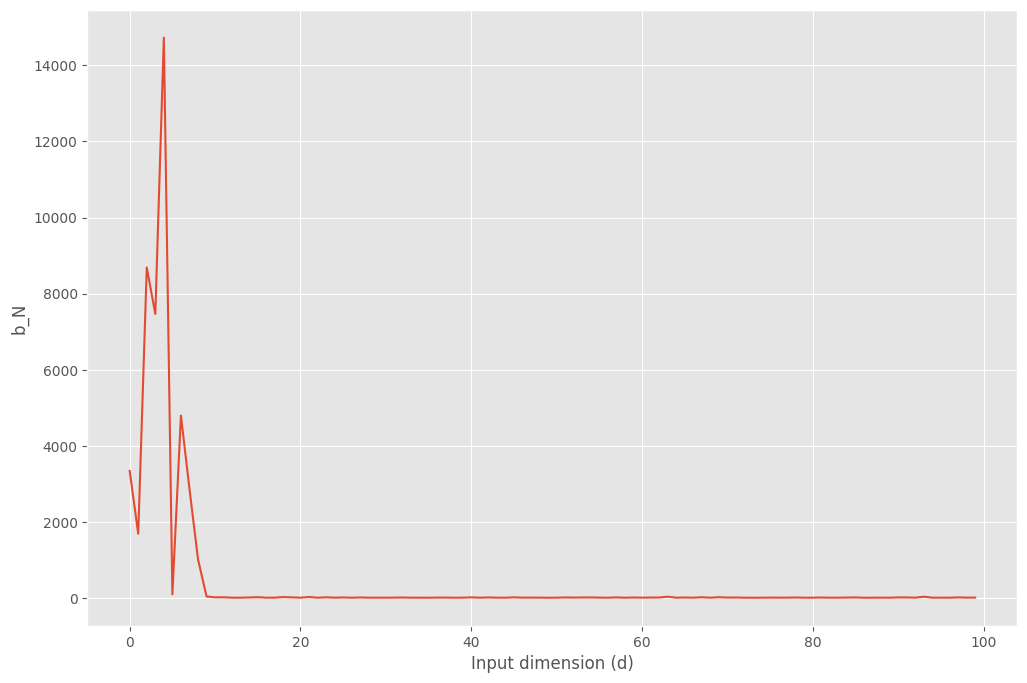

In [8]:
plt.plot(b_N)
plt.xlabel("Input dimension (d)")
plt.ylabel("b_N")
plt.show()

We can observe that the values of $b_N$ are very large (look at the scale!) for the first 10 input dimensions (the relevant ones) and close to 0 for the remaining input dimensions (i.e. irrelevant features). 

Therefore, this model is doing **feature selection** by automatically ignoring the irrelevant features. Hence the name: Automatic Relevance Determination (ARD)